# Exercise 3

In this assignment, you will find numerical solutions to the diffusion equation. In particular, you will use an implicit method, and consider problems with both Dirichlet and Neumann boundary conditions.

**Remember**
   * You are expected to use numpy and scipy libraries where appropriate.  
   * You should run each cell in order from the top of the notebook; there is no need to repeat code between cells
   * Use the "refresh kernel" button to reset everything and start again
   * Make sure your notebook runs fully & without errors, from a fresh kernel, before submitting it

## Problem Overview

The 1D diffusion equation is :

$$\frac{\partial u}{\partial t} = k\frac{\partial^2 u}{\partial x^2}$$

You should discretize this equation onto $N_x$ space points, with separation $\Delta x = h$, and into timesteps $\Delta t = \tau$.  In the equations below, I use subscript $i$ as a space index, and superscript $n$ for time indices.

Having discretized the problem, you should use the _implicit_ finite difference equation, as discussed in lectures :

$$\frac{u_i^{n+1} - u_i^n}{\tau} = k \frac{u_{i+1}^{n+1} - 2u_i^{n+1} + u_{i-1}^{n+1}}{h^2}$$

This can be written in matrix form $u^n = M u^{n+1}$ using :

$$u_i^n = - \alpha u_{i-1}^{n+1} + (1 + 2\alpha) u_i^{n+1} - \alpha u_{i+1}^{n+1}$$

where $\alpha = \frac{k \tau}{h^2}$.

In the problems below, you are asked to solve the diffusion equation in the context of the heat equation. Here, $k$ is the thermal diffusivity, given by $k = \frac{\lambda}{\rho C}$, where $\lambda$ is the thermal conductivity, $\rho$ is the density, and $C$ is the specific heat capacity. The questions below concern an iron poker of length 50cm.  You may take the thermal conductivity of iron to be a constant 59 W/m/K, its specific heat as 450 J/kg/K, and its density as 7,900 kg/m3.  You can ignore heat loss along the length of the poker.


## Part 1 - Dirichlet Boundary Conditions

The poker is initially in equilibrium, at room temperature of 20 C. At time $t = 0$, one end is thrust into a furnace at 1000 C and the other end is held in an ice bath at 0 C. Your task is to calculate the temperature distribution along the poker as a function of time.

The fact that the ends of the rod are held at fixed temperatures of 0 C and 1000 C corresponds to a Dirichlet boundary condition.  These can be included in the implicit method as follows.

The implicit finite difference equation, above, will allow us to calculate the unknown 'internal' nodes, ie. $0 < i < (N_x-1)$.  However, the boundary nodes, $i=0, N_x$, must have fixed values $d_0, d_N$.  To fix the boundaries, we take the matrix M to be of size $(N_x-2) \times (N_x-2)$, and adding a vector term :

$$u^n = Mu^{n+1} + b$$

For $N_x = 7$ (for example), this gives :

$$M = \begin{pmatrix}
1+2\alpha & -\alpha   &           &           &           \\
-\alpha   & 1+2\alpha & -\alpha   &           &           \\
          & -\alpha   & 1+2\alpha & -\alpha   &           \\
          &           & -\alpha   & 1+2\alpha & -\alpha   \\
          &           &           & -\alpha   & 1+2\alpha 
\end{pmatrix}$$

$$b = \begin{pmatrix}
-\alpha d_0 \\
0 \\
0 \\
0 \\
-\alpha d_N \\
\end{pmatrix}$$

You can show this gives the required finite equation for $i=1, (N-1)$, eg. :

$$u^n_1 = - \alpha u^{n+1}_2 + (1 + 2\alpha)u^{n+1}_1 - \alpha d_0$$

First, write functions that will construct the matrix equation and boundary value term.

In [196]:
import unittest
import numpy as np
import scipy.linalg as linalg
import matplotlib.pyplot as plt

# Solution is a data-class used to organise the objects required to 
# solve the diffusion equation.


class Diffusion_Solution:
    
    """Data-class used to organise the objects required to implicitly 
    solve the diffusion equation
    
    Parameters
    ----------
    boundary_types: tuple
        The possible boundary types that may be used.
    type: int
        The index of 'boundary_types' corresponding to the type of 
        boundary conditions used.
        0: 'Dirichlet'
        1: 'Neumann'

    bounds: NOTE fill in later!!

    matrix: array-like
        Matrix used to solve the diffusion equation for the specific
        boundary conditions.
    lu: LU_Decomposition object
        LU decomposition of matrix.
    
    coords_current: NOTE fill in later!

    """
    boundary_types = ("Dirichelt", "Neumann")

    def __init__(self, type):
        self.type = self.boundary_types[type]
        self.bounds = None
        self.matrix = None
        self.lu = None
        self.coords_current = None
        self.coords_all = None
        self.spatial = None


class LU_Decomposition:
    """Data-class used to organise the LU decomposition of a square 
    matrix

    Parameters
    ----------
    p: array-like
        Permutation matrix.
    l: array-like
        Lower triangular matrix with unit diagonal.
    u: array-like
        Upper triangular matrix.
    """
    def __init__(self, p, l, u):
        self.p = p
        self.l = l
        self.u = u


def create_dirichlet(x_n, x_step, t_step, k, bounds):
    """Creates matrix and boundary vector required to solve the 
    diffusion equation in 1D with Dirichlet boundary conditions.

    Parameters
    ----------
    x_n: int
        The number of spatial steps.
    x_step: float
        The size of each spatial step.
    t_step: float
        The size of each time step.
    k: float
        The thermal diffusivity.
    bounds: array-like
        The ordered boundary conditions at either end of the 1D shape. 
        The first boundary condition will correspond to the 0th element 
        of the final solution while the first element will correspond 
        to the final element. 

    Returns
    -------
    matrix: ndarray
        A two dimensional array containing the diffusion matrix
        required to solve the diffusion equation in 1D.
    bounds: ndarray
        The Dirichlet boundary vector.        
    """
    # Create the marix M
    # Check that x_n is of the correct form
    if (x_n := int(x_n)) < 1:
        raise ValueError("at least one spacial step required")
    alpha = k*t_step/np.square(x_step)
    matrix = np.identity(x_n, dtype=np.float64) * (1+2*alpha)
    np.fill_diagonal(matrix[1:, :-1], -alpha)
    np.fill_diagonal(matrix[:-1, 1:], -alpha)

    # Create the boundary vector
    bound_arr = np.zeros(x_n)
    bound_arr[0], bound_arr[-1] = bounds
    bound_arr *= -alpha
    return matrix, bound_arr


class Test_Create_Dirichlet(unittest.TestCase):
    """Testing 'create_dirichlet' function.
    """
    def setUp(self):
        """Initialize the required parameters to print the test results
        and create arguments for 'create_dirichlet'.
        """
        self.print = False
        self.test_name = None
        self.result = "FAIL"
        self.output = None
        self.x_n = 2
        self.x_step = 1
        self.t_step = 1
        self.k = 1
        self.bounds = (0, 1)
        self.matrix_out, self.vect_out= create_dirichlet(
            self.x_n, self.x_step, self.t_step, self.k, self.bounds
        )

    def tearDown(self):
        """Print the test results to std.out
        """
        if self.print is not False:
            print(f"{self.test_name}: {self.result}")
            for i in enumerate(self.test_name):
                print('-', end='')
            print(f"-\n{self.output}\n")

    def test_bad_x_n(self):
        """Test that the function throws correct error given a bad x_n.
        """
        with self.assertRaises(ValueError):
            create_dirichlet(0, 1, 1, 1, (2, 2))
    
    def test_matrix_out(self):
        """Checks that the output matrix has the expected form.
        """
        self.print = True
        self.test_name = "TEST OUTPUT MATRIX"
        matrix_true = np.array([[3, -1],[-1, 3]], dtype=float)
        equal = np.allclose(self.matrix_out, matrix_true)
        self.output = "True matrix\n\t"
        self.output += str(matrix_true).replace('\n', '\n\t')
        self.output += " \nCalculated matrix\n\t"
        self.output += str(self.matrix_out).replace('\n', '\n\t')
        self.assertTrue(np.allclose(self.matrix_out, matrix_true))
        self.result = "SUCCESS"

    def test_vect_out(self):
        """Checks that the output boundary vector has the expected form.
        """
        self.print = True
        self.test_name = "TEST OUTPUT BOUNDARY VECTOR"
        alpha = self.k*self.t_step/np.square(self.x_step)
        vect_true = np.asarray(self.bounds)*(-alpha)
        self.output = f"True boundary vector\n\t{vect_true}\nCalculated boundary"
        self.output = f"{self.output} vector\n\t{self.vect_out}"
        self.assertTrue(np.allclose(vect_true, self.vect_out))
        self.result = "SUCCESS"

test_suite = unittest.makeSuite(Test_Create_Dirichlet)
runner = unittest.TextTestRunner(verbosity=0).run(test_suite)

----------------------------------------------------------------------
Ran 3 tests in 0.005s

OK


TEST OUTPUT MATRIX: SUCCESS
-------------------
True matrix
	[[ 3. -1.]
	 [-1.  3.]] 
Calculated matrix
	[[ 3. -1.]
	 [-1.  3.]]

TEST OUTPUT BOUNDARY VECTOR: SUCCESS
----------------------------
True boundary vector
	[-0. -1.]
Calculated boundary vector
	[-0. -1.]



Now write a function which will transport the temperature distribution at time step $n$ to time step $n+1$. You will need to use an appropriate linear algebra routine.

In [197]:
# Use LU decomposition to solve the equation Mu = u-b
def _get_LU(matrix):
    """LU factorise a matrix
    
    Parameters
    ----------
    matrix: array-like
        Square matrix for LU factorisation
    
    Returns
    -------
    lu_decomposition: LU_Decomposition object
        The LU decomposition of 'matrix'.
    
    """
    return LU_Decomposition(*linalg.lu(matrix))


def _solve_LU(lu_decomp, b):
    """Solves the equation A*x = b for x using the LU decomposition of 
    A.
    
    Parameters
    ----------
    lu_decomp: LU_Decomposition object
        The LU decomposition of A.
    b: array_like
    
    Returns
    -------
    x: array-like
    """
    y = linalg.solve(lu_decomp.p, b)
    z = linalg.solve_triangular(lu_decomp.l, y, lower=True)
    x = linalg.solve_triangular(lu_decomp.u, z)
    return x


def timestep_dirichlet(u_current, boundary_vect, t_n, matrix, method=0):
    """Solve the diffusion equation for the next N timesteps given 
    dirichlet boundary conditions.

    Paramters
    ---------
    u_current: array_like
    boundary_vect: array_like
    t_n: int
    matrix: array_like
    method: int
        Index for method used to solve for next timestep:
        0: Invert matrix and use matrix multiplication
        1: LU substitution
        2: scipy.linalg solve

    Returns
    -------
    u_iterations: ndarray
        (t_n, N) array where N is the number of elements u_current. The  
        ith subarray corresponds to the spatial distribution at time
        i*t_n. Thus, i = 0 corresponds to u_current. 
    """
    # Check for valid LU decomposition or calculate decomposition from 
    # matrix.
    allowed_method = (0, 1, 2)
    try:
        u_current = np.asarray(u_current)
        if u_current.ndim != 1:
            raise ValueError("u_current must be 1D")
    except Exception:                                                            
        u_type = u_current.__class__.__name__
        raise TypeError(f"{u_type} cannot be cast to ndarray")
    iterations = np.zeros([t_n+1, len(u_current)], dtype=float)
    iterations[0] = u_current
    tenth = int(t_n/10)
    step = (t_n)/100
    
    if method == 0:
        try:
            inverse = linalg.inv(matrix)
        except Exception:
            raise ValueError("unable to compute inverse from matrix")
        for i in range(t_n):
            if (i) % tenth == 0:
                print(f"{int(i/step)}% complete")
            iterations[i+1] = np.matmul(inverse, iterations[i]-boundary_vect)
    
    elif method == 1:
        try:
            lu_decomp = _get_LU(matrix)          
        except Exception:
            raise ValueError("unable to compute LU decomposition from matrix")
        for i in range(t_n):
            if (i) % tenth == 0:
                print(f"{int(i/step)}% complete")
            iterations[i+1] = _solve_LU(lu_decomp, iterations[i]-boundary_vect)
        
    elif method == 2:
        for i in range(t_n):
            if (i) % tenth == 0:
                print(f"{int(i/step)}% complete")
            iterations[i+1] = linalg.solve(matrix, iterations[i]-boundary_vect)

    else:
        raise ValueError("'method' must be an element of the set {0, 1, 2}")
    print("100% complete")
    return iterations


class Test_get_LU(unittest.TestCase):
    def test_output(self):
        """Test that the _get_LU function returns a LU_Decomposition 
        object which recombines into the original matrix
        """
        matrix_true = np.array([[4, 3], [6, 3]])
        lu_out = _get_LU(matrix_true)
        matrix_out = np.matmul(lu_out.l, lu_out.u)
        matrix_out = np.matmul(lu_out.p, matrix_out)
        self.assertTrue(np.allclose(matrix_out, matrix_true))
        self.assertIsInstance(lu_out, LU_Decomposition)


class Test_Solve_LU(unittest.TestCase):  
    def test_unique_output(self):
        """Test behaviour when matrix equation 'M*x = b' has a unique
        solution.
        """
        m = np.array([[1, 1, 2], [1, 1, 1], [0, 1, 1]], dtype=float)
        b = np.array([3, 2, 1], dtype=float)
        x_true = linalg.solve(m, b)
        lu_decomp = _get_LU(m)
        x_out = _solve_LU(lu_decomp, b)
        self.assertTrue(np.allclose(x_true, x_out))
        self.result = "SUCCESS"

class Test_Timestep_Dirichelt(unittest.TestCase):
    """Test 'timestep_dirichlet' to ensure it produces the correct
    spatial solutions for all inputs.
    """
    def setUp(self):
        self.x_n = 3
        self.x_step = 1
        self.t_n = 1
        self.t_step = 1
        self.k = 1
        self.bounds = (0, 2)
        self.solution = Diffusion_Solution(0)
        self.solution.bounds
        self.solution.coords_current = np.ones(self.x_n, dtype=float)
        self.solution.matrix, self.solution.bounds = create_dirichlet(
            self.x_n, self.x_step, self.t_step, self.k, self.bounds
        )
        self.solution.lu = _get_LU(self.solution.matrix)
        timestep = linalg.solve(self.solution.matrix,
                self.solution.coords_current - self.solution.bounds
        )
        self.coords_true = np.concatenate(
            [self.solution.coords_current, timestep]
        ).reshape(2, 3)

    def test_lu_decomp(self):
        """Test solution when passed a LU_Decomposition and a boundary
        vector. 
        """
        self.solution.coords_all = timestep_dirichlet(
            self.solution.coords_current,
            self.solution.bounds,
            self.t_n,
            lu_decomp=self.solution.lu
        )
        self.assertTrue(
            np.allclose(self.coords_true, self.solution.coords_all)
        )
    
    def test_matrix(self):
        """Test solution when passed a matrix and a boundary condition
        without a LU_Decomposition.
        """
        coords_out = timestep_dirichlet(
            self.solution.coords_current,
            self.solution.bounds,
            self.t_n,
            matrix=self.solution.matrix
        )
        self.assertTrue(np.allclose(self.coords_true, coords_out))


loader = unittest.TestLoader()
test_suite = unittest.TestSuite()
test_suite.addTest(unittest.makeSuite(Test_get_LU))
test_suite.addTest(unittest.makeSuite(Test_Solve_LU))
test_suite.addTest(unittest.makeSuite(Test_Timestep_Dirichelt))
runner = unittest.TextTestRunner(verbosity=1).run(test_suite)

..EE
ERROR: test_lu_decomp (__main__.Test_Timestep_Dirichelt)
Test solution when passed a LU_Decomposition and a boundary
----------------------------------------------------------------------
Traceback (most recent call last):
  File "C:\Users\vidar\AppData\Local\Temp/ipykernel_12344/875353981.py", line 164, in test_lu_decomp
    self.solution.coords_all = timestep_dirichlet(
TypeError: timestep_dirichlet() got an unexpected keyword argument 'lu_decomp'

ERROR: test_matrix (__main__.Test_Timestep_Dirichelt)
Test solution when passed a matrix and a boundary condition
----------------------------------------------------------------------
Traceback (most recent call last):
  File "C:\Users\vidar\AppData\Local\Temp/ipykernel_12344/875353981.py", line 178, in test_matrix
    coords_out = timestep_dirichlet(
  File "C:\Users\vidar\AppData\Local\Temp/ipykernel_12344/875353981.py", line 83, in timestep_dirichlet
    if (i) % tenth == 0:
ZeroDivisionError: integer division or modulo by zero

-

Finally, use the functions above to calculate the temperature distribution as a function of time, and display this graphically using an appropriate plotting routine.

0% complete
10% complete
20% complete
30% complete
40% complete
50% complete
60% complete
70% complete
80% complete
90% complete
100% complete


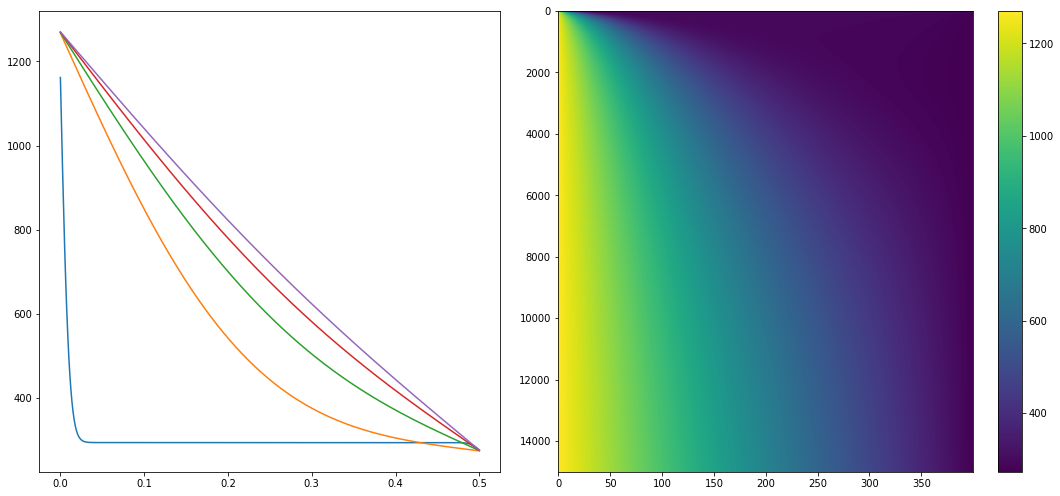

In [198]:
# Initial conditions
temp_0 = 293.15
x_n = 400
x_step = 0.5/x_n
t_n_max = 15000
t_step = 0.25
k = 59/(7900*450)
bounds = (1273.15, 273.15)
u_initial = np.full(x_n, temp_0, dtype=float)
spatial = np.linspace(0, x_n*x_step, x_n)

solution_dirichlet = Diffusion_Solution(0)
solution_dirichlet.coords_current = u_initial 
solution_dirichlet.spatial = spatial
solution_dirichlet.matrix, solution_dirichlet.bounds = create_dirichlet(
    x_n, x_step, t_step, k, bounds
)
solution_dirichlet.coords_all = timestep_dirichlet(
    solution_dirichlet.coords_current,
    solution_dirichlet.bounds,
    t_n_max,
    solution_dirichlet.matrix,
)
# determine points to graph
graph_time_id = np.linspace(10, t_n_max-1, 5, dtype=int)
# graphing
fig_dir = plt.figure(figsize=[16, 8])
axes_graph = fig_dir.add_axes([0.1, 0.1, 0.4, 0.8])
for id, x in enumerate(graph_time_id):
    axes_graph.plot(solution_dirichlet.spatial, solution_dirichlet.coords_all[x])
axes_imshow = fig_dir.add_axes([0.55, 0.1, 0.45, 0.8])
im = axes_imshow.imshow(solution_dirichlet.coords_all, aspect='auto')
plt.colorbar(im, ax=axes_imshow)
plt.show()


## Part 2 - Neumann Boundary Conditions

Now we assume the far end of the poker from the furnace is no longer held at 0 C, but instead experiences no heat loss. Again your task is to find the tempeterature distribution as a function of time.

In this case, you will need to implement a Neumann boundary condition at the end of the poker, to ensure the derivative $\frac{\partial u}{\partial x}$ is zero. Since we are using finite differences, this is equivalent to ensuring the final two noces have the same value.

The finite difference equation for node $i=(N-1)$ is :

$$u^n_{N-1} = -\alpha u^{n+1}_{N-2} + (1 + 2\alpha)u^{n+1}_{N-1} - \alpha u^{n+1}_{N}$$

To enforce the Neumann boundary condition we can substitute $u^{n+1}_{N} = u^{n+1}_{N-1}$, giving :

$$u^n_{N-1} = -\alpha u^{n+1}_{N-2} + (1 + \alpha)u^{n+1}_{N-1}$$

This results in a modified form of $M$, shown here for the example $N_x=7$, and the matrix ix $5\times5$ :  

$$M = \begin{pmatrix}
1+2\alpha & -\alpha   &           &           &           & \\
-\alpha   & 1+2\alpha & -\alpha   &           &           & \\
          & -\alpha   & 1+2\alpha & -\alpha   &           & \\
          &           & -\alpha   & 1+2\alpha & -\alpha   & \\
          &           &           & -\alpha   & 1+\alpha & \\
\end{pmatrix}$$

Note that you will also need to include a boundary term vector $b$, since the end of the poker in the furnace still requires a Dirichlet condition.

First write any new functions you need. You should be able to re-use some functions from Part 1.

In [199]:
def create_neumann(x_n, x_step, t_step, k, bound):
    """Creates matrix and boundary vector required to solve the 
    diffusion equation in 1D with Neumann boundary conditions.

    Parameters
    ----------
    x_n: int
        The number of spatial steps.
    x_step: float
        The size of each spatial step.
    t_step: float
        The size of each time step.
    k: float
        The thermal diffusivity.
    bounds: array-like
        The ordered boundary conditions at either end of the 1D shape. 
        The first boundary condition will correspond to the 0th element 
        of the final solution while the first element will correspond 
        to the final element. 

    Returns
    -------
    matrix: ndarray
        A two dimensional array containing the diffusion matrix
        required to solve the diffusion equation in 1D.
    bounds: ndarray
        The Dirichlet boundary vector.        
    """
    # Create the marix M
    # Check that x_n is of the correct form
    if (x_n := int(x_n)) < 1:
        raise ValueError("at least one spacial step required")
    alpha = k*t_step/np.square(x_step)
    matrix = np.identity(x_n, dtype=np.float64) * (1+2*alpha)
    np.fill_diagonal(matrix[1:, :-1], -alpha)
    np.fill_diagonal(matrix[:-1, 1:], -alpha)
    matrix[x_n-1, x_n-1] = 1+alpha

    # Create the boundary vector
    bound_arr = np.zeros(x_n)
    bound_arr[0] = (-alpha)*bound
    return matrix, bound_arr

Finally, use the functions above to calculate the temperature distribution as a function of time, and display this graphically using a sensible plotting function.

0% complete
10% complete
20% complete
30% complete
40% complete
50% complete
60% complete
70% complete
80% complete
90% complete
100% complete


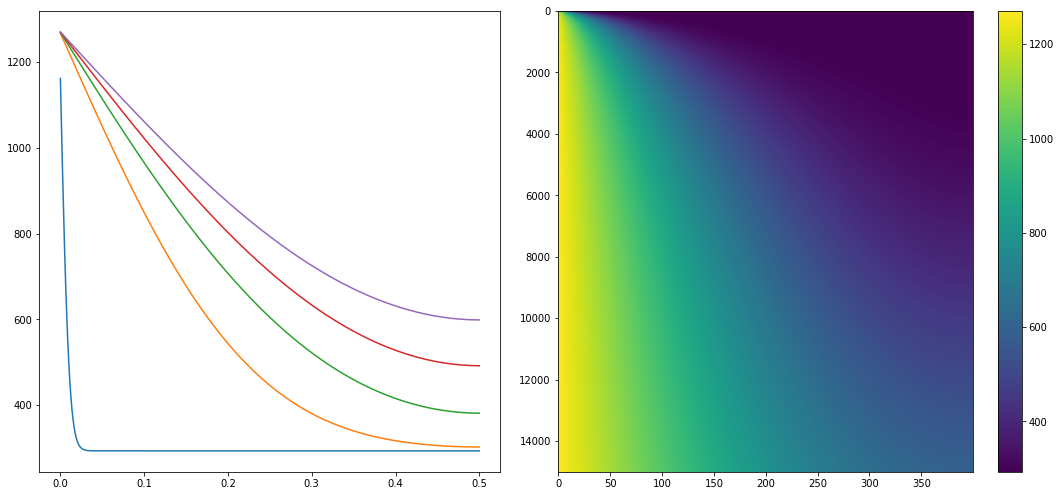

In [200]:
solution_neumann = Diffusion_Solution(1)
solution_neumann.coords_current = u_initial
solution_neumann.spatial = spatial
solution_neumann.matrix, solution_neumann.bounds = create_neumann(
    x_n, x_step, t_step, k, bounds[0]
)
solution_neumann.coords_all = timestep_dirichlet(
    solution_neumann.coords_current,
    solution_neumann.bounds,
    t_n_max,
    solution_neumann.matrix
)
# determine points to graph
graph_time_id = np.linspace(10, t_n_max-1, 5, dtype=int)
# graphing
fig_neu = plt.figure(figsize=[16, 8])
axes_graph = fig_neu.add_axes([0.1, 0.1, 0.4, 0.8])
for id, x in enumerate(graph_time_id):
    axes_graph.plot(solution_neumann.spatial, solution_neumann.coords_all[x])
axes_imshow = fig_neu.add_axes([0.55, 0.1, 0.45, 0.8])
im = axes_imshow.imshow(solution_neumann.coords_all, aspect='auto')
plt.colorbar(im, ax=axes_imshow)
plt.show()

# Part 3

In the Markdown cell below, describe how your code solves the problem set. State any equations used in the solution and how they were obtained. Include your reasons for any libraries you used, as well as any particular programming techniques. Explain your choice of any test cases. Finally, state any salient features of the results you obtained. You are not expected to write more than about 250-300 words.

*Taylor series expansion to approximate second derivative of function*

$$ f(a+x) = \sum_{i=0}^{\infty}{\frac{f^i(a)x^i}{i!}} \approx f(a) + xf'(a) + \frac{1}{2}x^2f''(a)$$
$$ f(a-x) = \sum_{i=0}^{\infty}{\frac{(-1)^if^i(a)x^i}{i!}} \approx f(a) -xf'(a) + \frac{1}{2}x^2f(a)$$
$$ \Rightarrow f(a+x) + f(a-x) \approx f(a) + xf'(a) + \frac{1}{2}x^2f''(a) + f(a) -xf'(a) + \frac{1}{2}x^2f(a)$$
$$ \Rightarrow f''(a) \approx f(a+x) + f(a-x) -2f(a)$$


Probably want to use successive over relaxation (SOR) method as this requires $ \sim \frac{1}{3}J $ iterations to converge compared to the $ \sim \frac{1}{2}J^2 $ interations required for the Jacobi and $ \sim \frac{1}{4} J^2 $ required for the Gauss-Seidel method.
The SOR method is given by the following equation(s):

$$ V'_{i,j} = V_{i,j} = \omega\left(\frac{V'_{i-1,j} + V_{i+1,j} + V'_{i,j-1}}{4} - (\mathrm{RH side}) - V_{i,j} \right) $$


Note that one requires $\omega \in (0, 2)$ for SOR to converge (see Numerical Recipes 3rd edition, chapter 20.5.1, page 1062)

*Crank-Nicholson method is a good way to model evolution in time*

Note: when using the implicit method one is evaluating $u_{t+1}$ through the relation:
$$ M^{-1}(u_{t+0} - b_t) = u_{t+1} $$


Thing to note:
Usually would write unittesting in a separate file however due to the way this task has been constructed this is obviously not possible.

Characteristic time is given by T = L^2/k (see: Baierlein, R. (1999) Thermal Physics, Cambridge, Cambridge University Press., pages 371-373)s.t. completion percentage is F(t)=F(0)*(1-e^(-t/T))
Characteristic time: 15064s

Note solving for the inverse and then using it to compute the next steps is vastly faster than any other solution
    - may also use LU decomposition but solving for the different arrays takes longer than matrix multiplication
    - may also solve directly but this is very slow in python